In [105]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from pandas import concat
from pandas import DataFrame
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from math import sqrt
import matplotlib#
# be able to save images on server
matplotlib.use('Agg')

import numpy as np

C:\Users\E3867~1.OLA\AppData\Local\Temp/ipykernel_6560/690899835.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [34]:
df = pd.read_csv("datasets/births_count.csv", delimiter = ";")

In [35]:
df.head(10)

,Date,Births
0,01.01.1959,35
1,02.01.1959,32
2,03.01.1959,30
3,04.01.1959,31
4,05.01.1959,44
5,06.01.1959,29
6,07.01.1959,45
7,08.01.1959,43
8,09.01.1959,38
9,10.01.1959,27


In [15]:
# df['t'] = [x for x in range(365)]

In [19]:
df

,Date,Births
0,01.01.1959,35
1,02.01.1959,32
2,03.01.1959,30
3,04.01.1959,31
4,05.01.1959,44
...,...,...
360,27.12.1959,37
361,28.12.1959,52
362,29.12.1959,48
363,30.12.1959,55


In [20]:
df['t-1'] = df['Births'].shift(1)
print(df)

           Date  Births   t-1
0    01.01.1959      35   NaN
1    02.01.1959      32  35.0
2    03.01.1959      30  32.0
3    04.01.1959      31  30.0
4    05.01.1959      44  31.0
..          ...     ...   ...
360  27.12.1959      37  34.0
361  28.12.1959      52  37.0
362  29.12.1959      48  52.0
363  30.12.1959      55  48.0
364  31.12.1959      50  55.0

[365 rows x 3 columns]


In [21]:
df

,Date,Births,t-1
0,01.01.1959,35,NaN
1,02.01.1959,32,35.0
2,03.01.1959,30,32.0
3,04.01.1959,31,30.0
4,05.01.1959,44,31.0
...,...,...,...
360,27.12.1959,37,34.0
361,28.12.1959,52,37.0
362,29.12.1959,48,52.0
363,30.12.1959,55,48.0


In [22]:
df['t+1'] = df['Births'].shift(-1)

In [23]:
df

,Date,Births,t-1,t+1
0,01.01.1959,35,NaN,32.0
1,02.01.1959,32,35.0,30.0
2,03.01.1959,30,32.0,31.0
3,04.01.1959,31,30.0,44.0
4,05.01.1959,44,31.0,29.0
...,...,...,...,...
360,27.12.1959,37,34.0,52.0
361,28.12.1959,52,37.0,48.0
362,29.12.1959,48,52.0,55.0
363,30.12.1959,55,48.0,50.0


In [36]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [37]:
data = series_to_supervised(df, 2, 2)

In [38]:
data

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t),var1(t+1),var2(t+1)
2,01.01.1959,35.0,02.01.1959,32.0,03.01.1959,30,04.01.1959,31.0
3,02.01.1959,32.0,03.01.1959,30.0,04.01.1959,31,05.01.1959,44.0
4,03.01.1959,30.0,04.01.1959,31.0,05.01.1959,44,06.01.1959,29.0
5,04.01.1959,31.0,05.01.1959,44.0,06.01.1959,29,07.01.1959,45.0
6,05.01.1959,44.0,06.01.1959,29.0,07.01.1959,45,08.01.1959,43.0
...,...,...,...,...,...,...,...,...
359,24.12.1959,38.0,25.12.1959,44.0,26.12.1959,34,27.12.1959,37.0
360,25.12.1959,44.0,26.12.1959,34.0,27.12.1959,37,28.12.1959,52.0
361,26.12.1959,34.0,27.12.1959,37.0,28.12.1959,52,29.12.1959,48.0
362,27.12.1959,37.0,28.12.1959,52.0,29.12.1959,48,30.12.1959,55.0


# MLP for Time Series Forecasting

In [40]:

# univariate mlp example

# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([40, 50, 60, 70])


In [41]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [42]:
y

array([40, 50, 60, 70])

In [45]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[80.17999]]


In [46]:
df = pd.read_csv("datasets/births_count.csv", delimiter = ";")

In [47]:
df

,Date,Births
0,01.01.1959,35
1,02.01.1959,32
2,03.01.1959,30
3,04.01.1959,31
4,05.01.1959,44
...,...,...
360,27.12.1959,37
361,28.12.1959,52
362,29.12.1959,48
363,30.12.1959,55


C:\Users\E3867~1.OLA\AppData\Local\Temp/ipykernel_6560/2562549741.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [93]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('datasets/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


C:\Users\E3867~1.OLA\AppData\Local\Temp/ipykernel_6560/3742432252.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


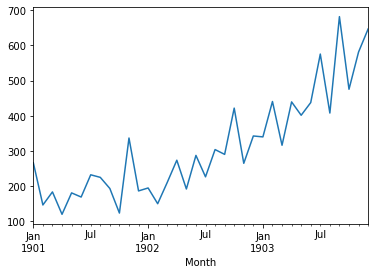

In [94]:
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [95]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [96]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df
 


In [97]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 


In [111]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [112]:
diff_values

0    -120.1
1      37.2
2     -63.8
3      61.0
4     -11.8
5      63.3
6      -7.3
7     -31.7
8     -69.9
9     213.6
10   -150.6
11      8.4
12    -44.8
13     60.6
14     63.2
15    -81.9
16     95.6
17    -61.0
18     77.6
19    -13.7
20    131.7
21   -157.1
22     77.8
23     -2.6
24    100.7
25   -124.5
26    123.4
27    -38.0
28     36.1
29    138.1
30   -167.9
31    274.4
32   -206.7
33    106.0
34     65.6
dtype: float64

In [98]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 


In [99]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 


In [107]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 


In [108]:
# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	model = Sequential()
	model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 


In [109]:
# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, lag)
	supervised_values = supervised.values[lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		train_trimmed = train_scaled[2:, :]
		model = fit_model(train_trimmed, batch_size, epochs, neurons)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		output = model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores
 


1) Test RMSE: 105.634
2) Test RMSE: 108.545
3) Test RMSE: 162.901
4) Test RMSE: 96.131
5) Test RMSE: 127.972
6) Test RMSE: 196.929
7) Test RMSE: 182.564
8) Test RMSE: 135.361
9) Test RMSE: 165.008
10) Test RMSE: 120.800
11) Test RMSE: 110.188
12) Test RMSE: 142.617
13) Test RMSE: 151.267
14) Test RMSE: 104.017
15) Test RMSE: 146.208
16) Test RMSE: 157.582
17) Test RMSE: 215.211
18) Test RMSE: 135.124
19) Test RMSE: 116.856
20) Test RMSE: 94.543
21) Test RMSE: 190.529
22) Test RMSE: 243.897
23) Test RMSE: 120.791
24) Test RMSE: 110.478
25) Test RMSE: 108.251
26) Test RMSE: 94.954
27) Test RMSE: 113.997
28) Test RMSE: 181.098
29) Test RMSE: 110.924
30) Test RMSE: 116.008
1) Test RMSE: 135.232
2) Test RMSE: 111.721
3) Test RMSE: 96.738
4) Test RMSE: 188.618
5) Test RMSE: 166.195
6) Test RMSE: 212.320
7) Test RMSE: 143.840
8) Test RMSE: 139.068
9) Test RMSE: 155.543
10) Test RMSE: 96.103
11) Test RMSE: 139.074
12) Test RMSE: 94.073
13) Test RMSE: 102.052
14) Test RMSE: 106.877
15) Test RMS

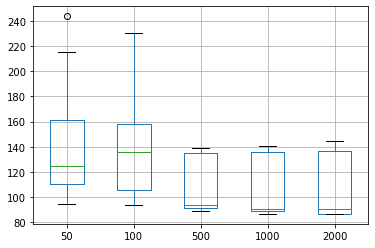

In [110]:
# load dataset
series = read_csv('datasets/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# experiment
repeats = 30
results = DataFrame()
lag = 1
neurons = 1
# vary training epochs
epochs = [50, 100, 500, 1000, 2000]
for e in epochs:
	results[str(e)] = experiment(repeats, series, e, lag, neurons)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_epochs.png')

In [117]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# forecast dataset
	output = model.predict(X, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	return rmse
 
# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	# prepare model
	model = Sequential()
	model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history
 

0) TrainRMSE=67.929269, TestRMSE=87.079603
1) TrainRMSE=91.943365, TestRMSE=135.840742
2) TrainRMSE=91.943363, TestRMSE=142.124431
3) TrainRMSE=64.607098, TestRMSE=92.363517
4) TrainRMSE=67.888103, TestRMSE=86.839463
5) TrainRMSE=64.616971, TestRMSE=92.409239
6) TrainRMSE=61.740571, TestRMSE=89.072030
7) TrainRMSE=68.015349, TestRMSE=87.314681
8) TrainRMSE=67.852863, TestRMSE=86.694261
9) TrainRMSE=64.607066, TestRMSE=92.362994


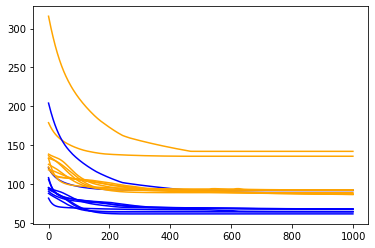

In [118]:
# run diagnostic experiments
def run():
	# config
	repeats = 10
	n_batch = 4
	n_epochs = 1000
	n_neurons = 1
	n_lag = 1
	# load dataset
	series = read_csv('datasets/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# run diagnostic tests
	for i in range(repeats):
		history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.savefig('diagnostic_epochs.png')
 
# entry point
run()